# Learning Stable Control-oriented Deep Koopman Operators  


This tutorial demonstrates the use of [Deep Koopman Operators](https://www.nature.com/articles/s41467-018-07210-0) (DeepKO) with stability guarantees for system identificaiton of nonautonomous nonlinear dynamical systems in NeuroMANCER. 


## Koopman System Identification with Control Problem Setup

<img src="../figs/Koopman_model.png" width="500">  


System observables  $y_{k}$ and control inputs $u_k$ are encoded via encoder neural networks $f_y$ and $f_u$ to generate latent states $x_{k}$ (linear coordinates). This coordinate transformation now allos to apply linear Koopman operator $K$ to obtain latent states at the next time step $x_{k+1}$. After the rollout over given prediction horizon $N$ the generated latent trajectories $\{x_1, ..., x_N \}$ are proejcted back to the observable space via decoder neural network $f_y^{-1}$.
Now this Koopman encoder-decoder model can be trained as any other black-box nonlinear system identification problem with the loss $\mathcal{L}$ evaluated by comparing the  trajectory generated by the model with the training trajectory. 


### Koopman with Control References

[1] [H. Shi and M. Q. . -H. Meng, "Deep Koopman Operator With Control for Nonlinear Systems," in IEEE Robotics and Automation Letters, vol. 7, no. 3, pp. 7700-7707, July 2022, doi: 10.1109/LRA.2022.3184036.](https://ieeexplore.ieee.org/document/9799788)  
[2] [Eurika Kaiser and J Nathan Kutz and Steven L Brunton, Data-driven discovery of Koopman eigenfunctions for control, Mach. Learn.: Sci. Technol. 2021](https://iopscience.iop.org/article/10.1088/2632-2153/abf0f5)  
[3] [M. Korda and I. Mezić, "Optimal Construction of Koopman Eigenfunctions for Prediction and Control," in IEEE Transactions on Automatic Control, vol. 65, no. 12, pp. 5114-5129, Dec. 2020](https://ieeexplore.ieee.org/document/9022864)  
[4] [Yiqiang Han, Wenjian Hao, Umesh Vaidya, Deep Learning of Koopman Representation for Control, 2020
](https://arxiv.org/abs/2010.07546)  
[6] [Minghao Han, Jacob Euler-Rolle, Robert K. Katzschmann, DeSKO: Stability-Assured Robust Control with a Deep Stochastic Koopman Operator, ICLR 2022](https://openreview.net/forum?id=hniLRD_XCA)  
[6] https://github.com/HaojieSHI98/DeepKoopmanWithControl


### Generic Stable Layers References
[7]  [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021, pp. 3993-4000](https://ieeexplore.ieee.org/document/9482930)   
[8] [J. Drgoňa, A. Tuor, S. Vasisht and D. Vrabie, "Dissipative Deep Neural Dynamical Systems," in IEEE Open Journal of Control Systems, 2022](https://ieeexplore.ieee.org/abstract/document/9809789)  
[9] [Jiong Zhang, Qi Lei, Inderjit S. Dhillon, Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization, InternationalConferenceonMachine Learning, 2018](https://arxiv.org/abs/1803.09327)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [359]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle 
import scipy
import time as tim

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks
import joblib

from sklearn.preprocessing import StandardScaler
torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation
- IverSimple

# Get and save data - (Already done)

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.

In [360]:
with open('data/train_real.pkl', 'rb') as fp:
        train_sim = pickle.load(fp)

with open('data/test_real.pkl', 'rb') as fp:
        test_sim = pickle.load(fp)

In [361]:
def get_data(nx, nu, nsim, nsteps, bs, scaler, scalerU):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """

    with open('data/train_real.pkl', 'rb') as fp:
        train_sim = pickle.load(fp)
        
    with open('data/train_real.pkl', 'rb') as fp:
        dev_sim = pickle.load(fp)

    with open('data/test_real.pkl', 'rb') as fp:
        test_sim = pickle.load(fp)
    
    train_sim['Y'] = np.vstack((train_sim['Y'], test_sim['Y']))
    train_sim['U'] = np.vstack((train_sim['U'], test_sim['U']))
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps


    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}

    return train_loader, dev_loader, test_data

In [362]:
nsim = train_sim['Y'].shape[0]   # number of simulation steps in the dataset
nsteps = 80   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size

scaler = StandardScaler()
scaler.fit(train_sim['Y'])  # Fit only on training data
joblib.dump(scaler, 'data/scaler.pkl')

scalerU = StandardScaler()
scalerU.fit(train_sim['U'])
joblib.dump(scalerU, 'data/scalerU.pkl')

nx = train_sim['Y'].shape[1]
ny = train_sim['Y'].shape[1]
nu = train_sim['U'].shape[1]

train_loader, dev_loader, test_data = get_data(nx, nu, nsim, nsteps, bs, scaler, scalerU)

In [363]:
scaler.inverse_transform([[0]])

array([[46.99871319]])

## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

<img src="../figs/Koopman_model.png" width="500">  


Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [364]:
# model parameters
nx_koopman = 10#
nx_koopman_baseline = 80
# n_hidden = 32
# n_layers = 2
layers = [60,60,60]
layers_baseline = [60,60,60]

**Encoder and Decoder networks** 

In [365]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [366]:
# instantiate input encoder net f_u

f_u = torch.nn.Linear(nu, nx_koopman, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [367]:
# instantiate state decoder neural net f_y_inv
# f_y_inv = blocks.MLP(nx_koopman, ny, bias=True,
#                 linear_map=torch.nn.Linear,
#                 nonlin=torch.nn.ELU,
#                 hsizes=n_layers*[n_hidden])
f_y_inv = torch.nn.Linear(nx_koopman, ny, bias=False)
# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [368]:
f_y_baseline = blocks.MLP(
    ny,
    nx_koopman_baseline,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers_baseline,
)
# initial condition encoder
encode_Y0_baseline = Node(f_y_baseline, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y_baseline = Node(f_y_baseline, ['Y'], ['x_latent'], name='encoder_Y')

f_u_baseline = torch.nn.Linear(nu, nx_koopman_baseline, bias=False)
# initial condition encoder
encode_U_baseline = Node(f_u_baseline, ['U'], ['u_latent'], name='encoder_U')
# instantiate state decoder neural net f_y_inv
f_y_inv_baseline = blocks.MLP(nx_koopman_baseline, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=layers_baseline)
# f_y_inv = torch.nn.Linear(nx_koopman, ny, bias=False)
# predicted trajectory decoder
decode_y_baseline = Node(f_y_inv_baseline, ['x'], ['yhat'], name='decoder_y')

**Standard Koopman Operator** without stability guarantees is parametrized by linear layer of the latent size. 

**Stable Koopman Operator:**  For provably stable Koopman operator we can choose a range of linear algebra factorization that allow to constrain the eigenvalues of the resulting linear operator. 
In this example we use the following [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization of the operator given as:
$$K = U \Sigma V$$ 
$$\Sigma =  \text{diag}(\lambda_{\text{max}} - (\lambda_{\text{max}} - \lambda_{\text{min}}) \cdot \sigma(\Lambda)) $$
where $\sigma$ is logistic sigmoid activation function, $\cdot$ is a dot product, $\Lambda$ is a vector of eigenvalues of the linear operator, while $\lambda_{\text{max}}$ and $\lambda_{\text{min}}$ are constraints on maximum and minimum value of SVD factorized linear operator.

<img src="../figs/SVD_layer.png" width="300">  

In order for the SVD factorization to hold the left and right matrices $U$ and $V$, respectively, needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix).
This can be achieved either via [Householder reflectors](https://arxiv.org/abs/1803.09327), or via penalties in the loss function given as:  
$$\ell_{U} = || I - UU^T||_2 + || I - U^TU||_2  $$
$$\ell_{V} = || I - VV^T||_2 + || I - V^TV||_2  $$
$$\ell_{\text{stable}} = \ell_{U} + \ell_{V} $$

For more details on the SVD and other linear algebra factorizations of trainable linear layers see the references [[7]](https://ieeexplore.ieee.org/document/9482930) and [[8]](https://ieeexplore.ieee.org/abstract/document/9809789), with Pytorch implementations in the [slim submodule](https://github.com/pnnl/neuromancer/tree/master/src/neuromancer/slim) of the Neuromancer library. 

In [369]:
# instantiate Koopman operator matrix
stable = False     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)
    K_baseline = torch.nn.Linear(nx_koopman_baseline, nx_koopman_baseline, bias=False)

In [370]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K x_k + u_k
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nx])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [371]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ['x', 'u_latent'], ['x'], name='K')
Koopman_baseline = Node(Koopman_control(K_baseline), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)
dynamics_model_baseline = System([Koopman_baseline], name='Koopman', nsteps=nsteps)

In [372]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

nodes_baseline = [encode_Y0_baseline, encode_Y_baseline, encode_U_baseline, dynamics_model_baseline, decode_y_baseline]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [373]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 20.*(yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"


# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"


## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [374]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

problem_baseline = Problem(nodes_baseline, loss)

In [375]:
problem_baseline.load_state_dict(torch.load('data/model_baseline.pth'),strict=False)

<All keys matched successfully>

In [376]:
# plot computational graph
#problem.show()
print(problem.input_keys)
print(problem.output_keys)

['Y', 'u_latent', 'yhat', 'x_latent', 'Y0', 'U', 'x']
['C_ineq_violations', 'C_ineq_values', 'penalty_loss', 'loss', 'C_eq_values', 'u_latent', 'objective_loss', 'yhat', 'x_latent', 'C_eq_violations', 'C_violations', 'C_values', 'x']


## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [377]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=200,
    warmup=100,
    epochs=2000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [378]:
# %% train
start = tim.time()
best_model = trainer.train()
problem.load_state_dict(best_model)
end = tim.time()


epoch: 0  train_loss: 23.146381378173828
epoch: 1  train_loss: 22.477102279663086
epoch: 2  train_loss: 21.851245880126953
epoch: 3  train_loss: 21.24193000793457
epoch: 4  train_loss: 20.64720344543457
epoch: 5  train_loss: 20.055139541625977
epoch: 6  train_loss: 19.468549728393555
epoch: 7  train_loss: 18.876657485961914
epoch: 8  train_loss: 18.273887634277344
epoch: 9  train_loss: 17.660301208496094
epoch: 10  train_loss: 17.031890869140625
epoch: 11  train_loss: 16.374061584472656
epoch: 12  train_loss: 15.687811851501465
epoch: 13  train_loss: 14.975093841552734
epoch: 14  train_loss: 14.231380462646484
epoch: 15  train_loss: 13.46170425415039
epoch: 16  train_loss: 12.666238784790039
epoch: 17  train_loss: 11.850306510925293
epoch: 18  train_loss: 11.019866943359375
epoch: 19  train_loss: 10.186279296875
epoch: 20  train_loss: 9.35266399383545
epoch: 21  train_loss: 8.525106430053711
epoch: 22  train_loss: 7.716403484344482
epoch: 23  train_loss: 6.935596942901611
epoch: 24  tr

In [379]:
import datetime

# Generate a string with the current timestamp
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

#torch.save(best_model, "./data/model_" + timestamp_str + ".pth")
torch.save(best_model, "./data/modelC.pth")

In [380]:
# # load problem
#problem.load_state_dict(torch.load('./data/modelC.pth'),strict=False)

In [381]:
# elapsed time
# print(f"Elapsed time train: {end-start:.2f} sec")


## System Identification results

In [382]:
problem.nodes

ModuleList(
  (0): encoder_Y0(Y0) -> x
  (1): encoder_Y(Y) -> x_latent
  (2): encoder_U(U) -> u_latent
  (3): System(
    (nodes): ModuleList(
      (0): K(x, u_latent) -> x
    )
  )
  (4): decoder_y(x) -> yhat
)

In [383]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = 3600

In [384]:
# Test set results
start = tim.time()
test_outputs = problem.step(test_data)
end = tim.time()
print(f"Elapsed time test: {end-start:.2f} sec")

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, nx).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T

Elapsed time test: 0.69 sec


In [385]:
problem_baseline.nodes[3].nsteps = 3600

start = tim.time()
test_outputs = problem_baseline.step(test_data)
end = tim.time()
print(f"Elapsed time test: {end-start:.2f} sec")

baseline_y = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T

Elapsed time test: 1.26 sec


In [386]:
np.mean((pred_traj - true_traj) ** 2)
#2*60; 40 0.06774564
#3*60 80 0.05942205
# 16 32 64 40 0.06478106
# 16 32 64 64 0.06103883
# 16 32 64 128 0.07568752
# 32 64 128 128 0.061701212


0.020537183

In [387]:
from scipy.signal import cont2discrete

# Given parameters
gain = 0.9669039581491512    # Example gain
tau = 69  # Example time constant
T = 1    # Sampling time (choose based on your application)

# Continuous-time state-space matrices
A = np.array([[-1/tau]])
B = np.array([[gain/tau]])
C = np.array([[1]])
D = np.array([[0]])

# Discretize using cont2discrete
system = (A, B, C, D)
discrete_system = cont2discrete(system, T, method='zoh')

# Extract discrete-time matrices
A_d, B_d, C_d, D_d, _ = discrete_system

print("Discrete A matrix:", A_d)
print("Discrete B matrix:", B_d)
print("Discrete C matrix:", C_d)
print("Discrete D matrix:", D_d)


Discrete A matrix: [[0.98561176]]
Discrete B matrix: [[0.01391205]]
Discrete C matrix: [[1]]
Discrete D matrix: [[0]]


In [388]:
x0 = test_data['Y0'][0].detach().numpy()
input_traj = test_data['U'].detach().numpy()[0]
y_strejc = np.zeros((nx, 3601))
y_strejc[:, 0] = x0
for i in range(3600):
    y_strejc[:,i+1] = A_d @ y_strejc[:,i] + B_d @ input_traj[i]
    #if i%50 == 0 and i<3599:
    #    y_strejc[:,i+1] = true_traj[:,i]
y_strejc = y_strejc.T

In [389]:
100%50

0

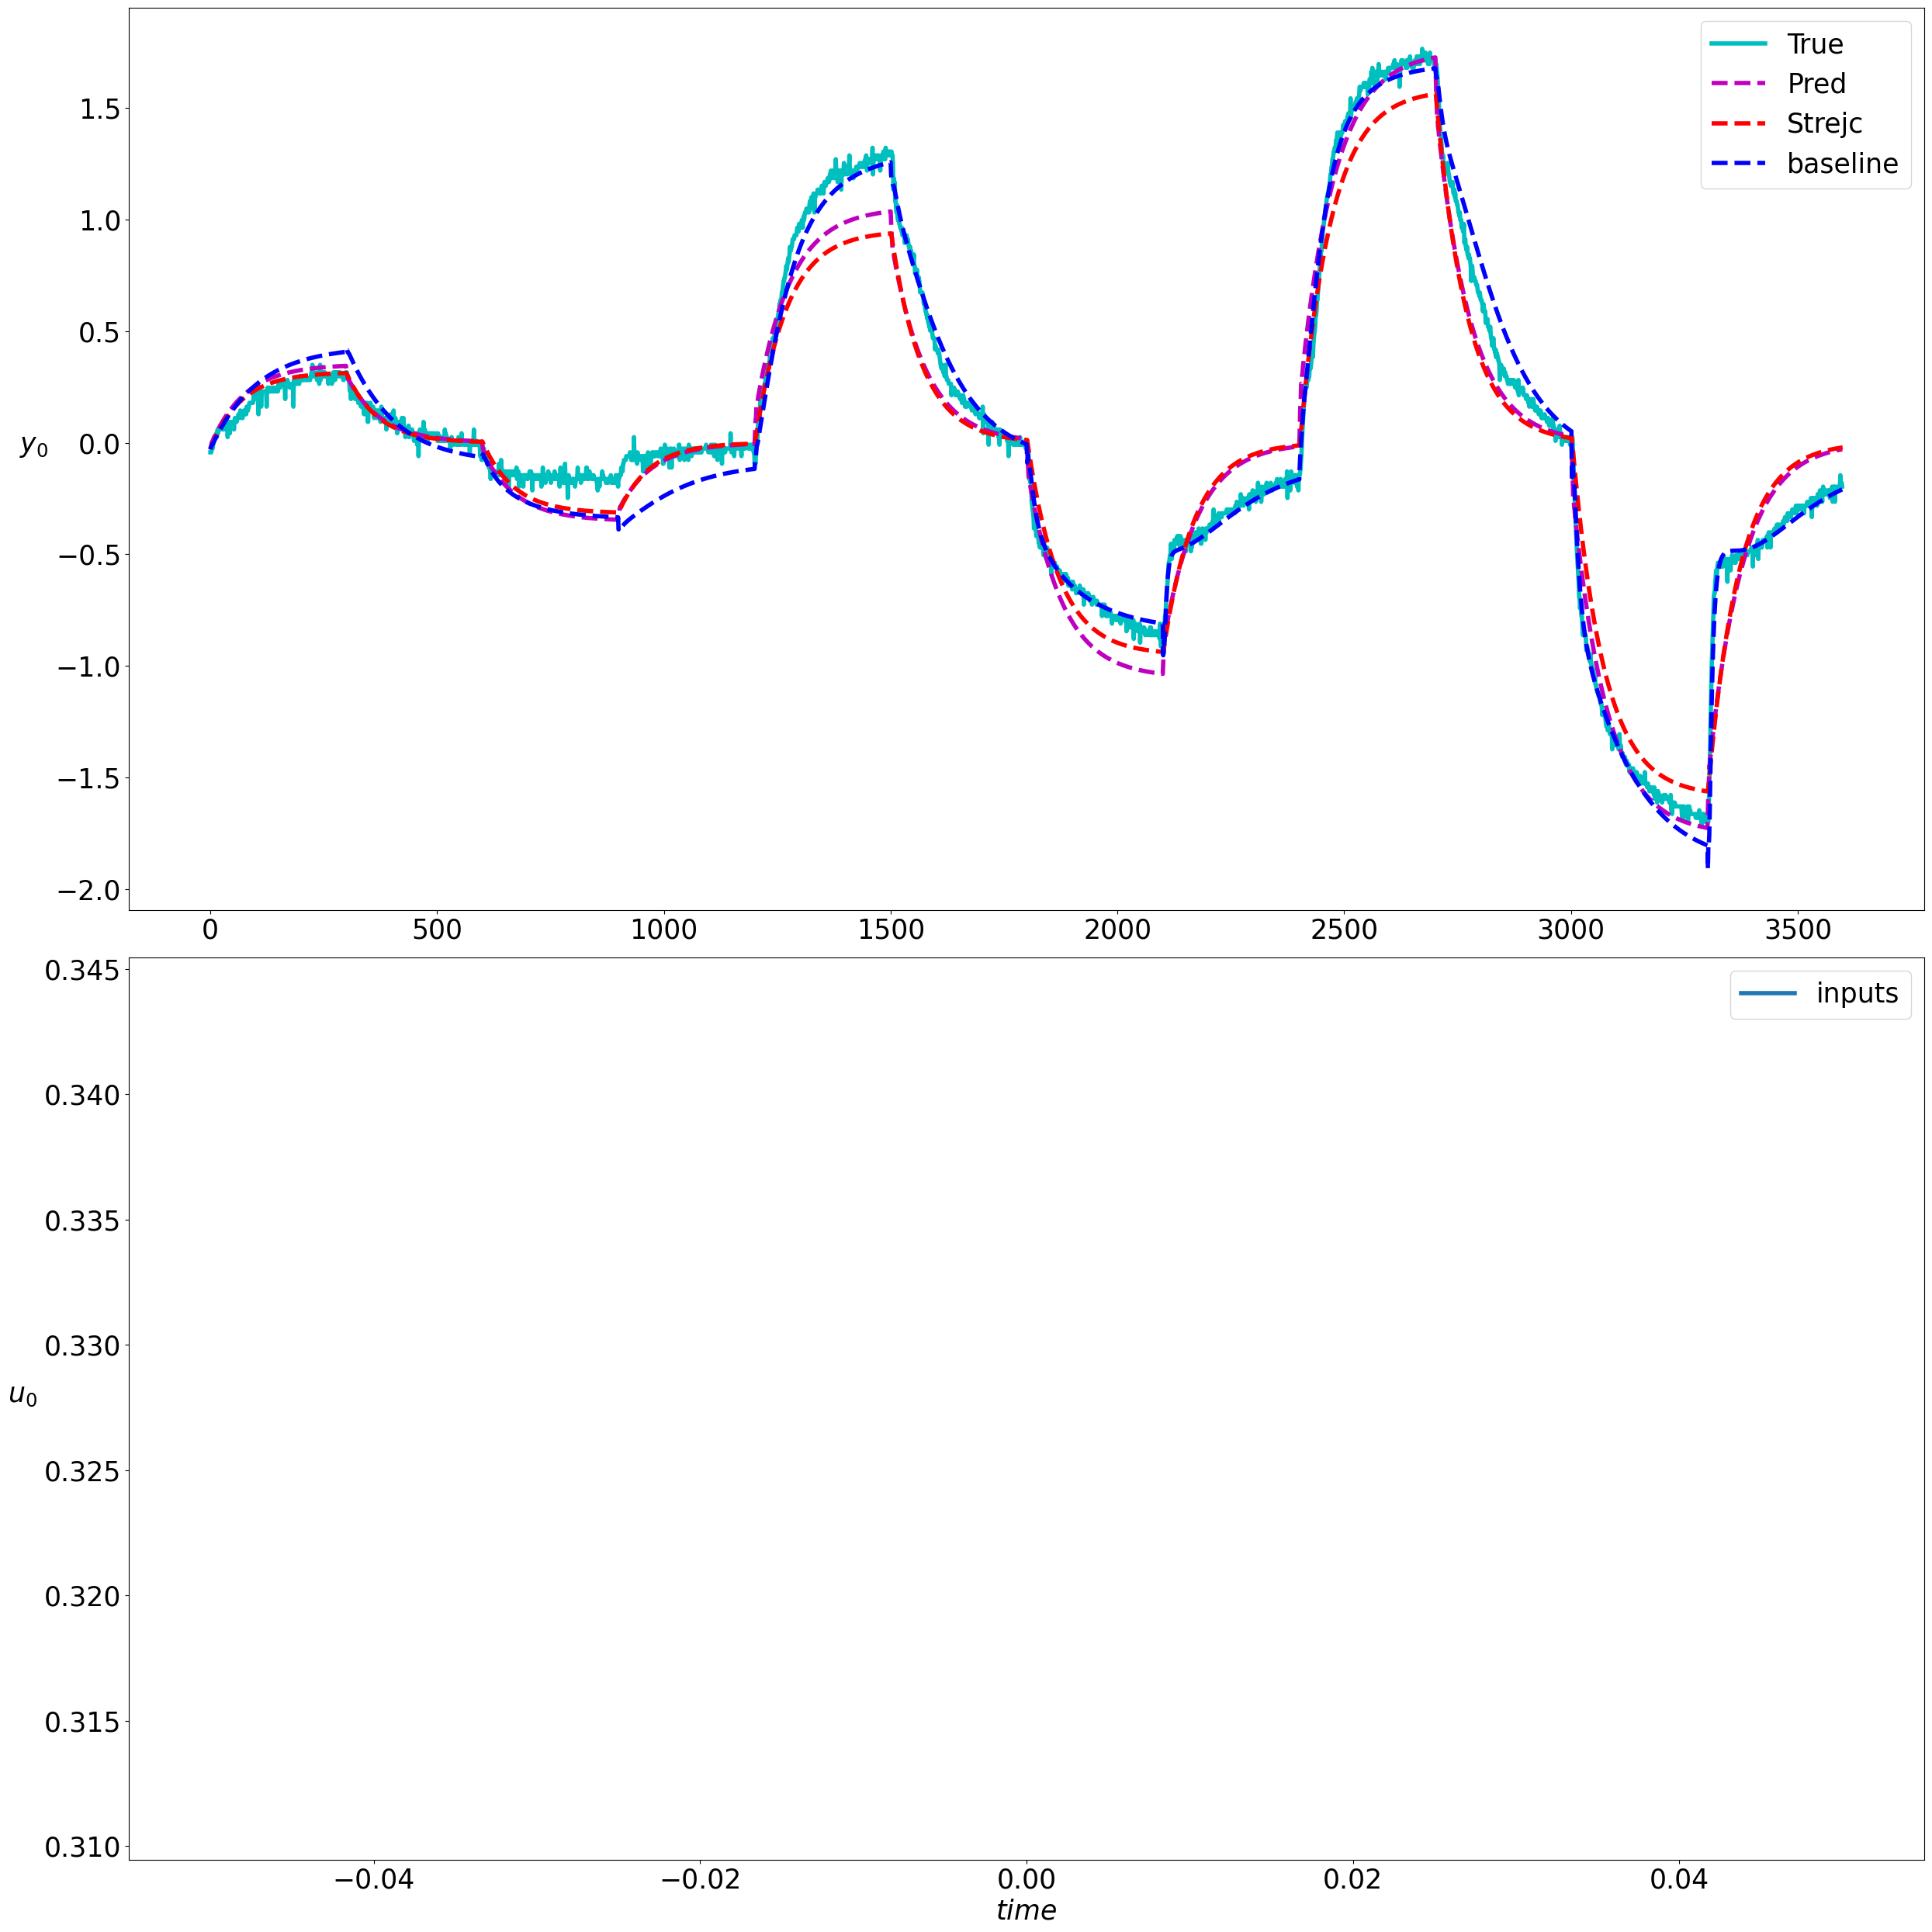

In [390]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))
part = 3600

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, t3, t4, label) in enumerate(zip(true_traj, pred_traj, y_strejc.T, baseline_y, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:part], 'c', linewidth=4.0, label='True')
    axe.plot(t2[:part], 'm--', linewidth=4.0, label='Pred')
    axe.plot(t3[:part], 'r--', linewidth=4.0, label='Strejc')
    axe.plot(t4[:part], 'b--', linewidth=4.0, label='baseline')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(1)]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[1]# ax[row+nx]
    axe.plot(u[:part].T, linewidth=4.0, label='inputs')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [391]:
true_traj[0]

array([-0.04316736, -0.04316736, -0.04316736, ..., -0.17959893,
       -0.17959893, -0.19665287], dtype=float32)

In [392]:
# part = 300
# jump = 10*part-part

# xs = scaler.inverse_transform([[0]])
# x0 = scaler.inverse_transform([true_traj[:,jump]])
# input_traj = scalerU.inverse_transform(test_data['U'][:,jump:jump+part].detach().numpy()[0])-50
# y_strejc = np.zeros((nx, part+1))
# y_strejc[:, 0] = x0-xs#x0
# for i in range(part):
#     y_strejc[:,i+1] = A_d @ y_strejc[:,i] + B_d @ input_traj[i]
# y_strejc = scaler.transform((y_strejc+xs).T)  


# # plot trajectories
# figsize = 25
# fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))


# x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
# for row, (t1, t2, t3, label) in enumerate(zip(true_traj, pred_traj, y_strejc.T, x_labels)):
#     axe = ax[row]
#     axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
#     axe.plot(t1[jump:jump+part], 'c', linewidth=4.0, label='True')
#     axe.plot(t2[jump:jump+part], 'm--', linewidth=4.0, label='Pred')
#     axe.plot(t3[:part], 'r--', linewidth=4.0, label='Strejc')
#     axe.tick_params(labelbottom=False, labelsize=figsize)
# axe.tick_params(labelbottom=True, labelsize=figsize)
# axe.legend(fontsize=figsize)



In [393]:
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()
C = f_y_inv.weight.detach().numpy()
D = np.zeros((ny, nu))

np.save('./data/A_wC.npy', A)
np.save('./data/B_wC.npy', B)
np.save('./data/C_wC.npy', C)

In [394]:
def controllability_test(A, B):
    """
    Test the controllability of a system given state-space matrices A and B.

    Parameters:
    A (ndarray): State matrix of size (n, n)
    B (ndarray): Input matrix of size (n, m)

    Returns:
    bool: True if the system is controllable, False otherwise.
    """
    n = A.shape[0]  # Number of states
    controllability_matrix = B
    
    # Compute [B, AB, A^2B, ..., A^(n-1)B]
    for i in range(1, n):
        controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(A, i) @ B))
    
    # Check rank of the controllability matrix
    rank = np.linalg.matrix_rank(controllability_matrix)
    return rank == n

is_controllable = controllability_test(A, B)
print(f"System is controllable: {is_controllable}")

def analyze_controllability(A, B):
    n = A.shape[0]
    controllability_matrix = B
    for i in range(1, n):
        controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(A, i) @ B))
    
    rank = np.linalg.matrix_rank(controllability_matrix)
    return controllability_matrix, rank

C_matrix, rank = analyze_controllability(A, B)
print("Controllability Matrix:")
print(C_matrix)
print(f"Rank: {rank}/{A.shape[0]}")



System is controllable: True
Controllability Matrix:
[[ 6.57925725e-01 -1.61906511e-01  4.89696041e-02 -2.04116590e-02
   3.90799064e-03 -1.12846238e-03 -1.88445731e-03 -4.27088654e-03
  -4.07749927e-03 -4.68592206e-03]
 [ 5.97651899e-01 -3.53356674e-02 -4.92907278e-02 -9.85846110e-03
   1.53504135e-02  4.81294410e-04  1.83671038e-03  2.41096248e-04
   3.41375545e-03  2.81214993e-03]
 [-5.31830005e-02 -1.89189583e-01  2.55003031e-02 -2.68230848e-02
   5.16230799e-02 -2.50475425e-02  1.54612437e-02 -5.93317533e-03
   6.46375492e-03  2.02988856e-04]
 [-3.74158829e-01 -4.64844219e-02  4.80970331e-02  7.35001862e-02
   3.75479081e-04 -5.74888522e-03 -1.66897324e-03  4.53021564e-03
   2.40095123e-03  2.18732073e-03]
 [ 3.54198962e-02 -2.07502022e-01  9.28687453e-02  3.70396525e-02
   3.81680988e-02  1.36149535e-02  1.41617246e-02  1.12029649e-02
   1.35851568e-02  1.11360084e-02]
 [ 4.82889265e-01  1.29363894e-01 -1.58686563e-01  8.65833461e-02
  -2.19092965e-02 -7.28221890e-03 -6.47485116e

In [395]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

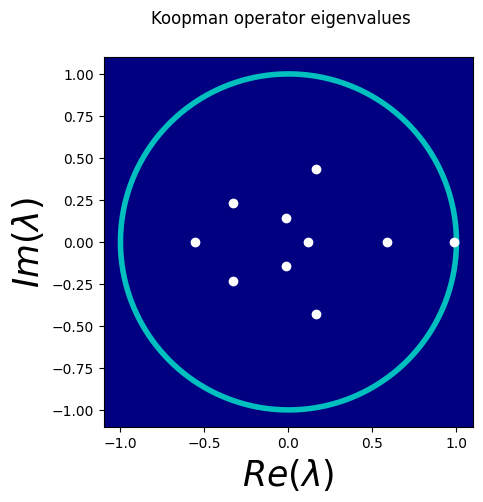

In [396]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=figsize)
ax1.set_ylabel("$Im(\lambda)$", fontsize=figsize)
fig1.suptitle('Koopman operator eigenvalues')


# Optimal Control


In [397]:
import sys
sys.path.append('../functions')

import numpy as np
from scipy.linalg import expm
import dense
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [398]:
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"][0].detach().numpy().reshape(1,-1).T

A_baseline = K_baseline.weight.detach().numpy()
B_baseline = f_u_baseline.weight.detach().numpy()

def get_x_baseline(y):
    x = problem_baseline.nodes[0]({"Y0": torch.from_numpy(y.reshape(1,-1,1)).float()})
    return x["x"][0].detach().numpy().reshape(1,-1).T

def y_plus_baseline(x,u):
    x_plus = A_baseline@x + B_baseline@u
    y_plus = problem_baseline.nodes[4]({"x": torch.from_numpy(x_plus).float()})
    return y_plus["yhat"][0].detach().numpy().reshape(1,-1).T, x_plus

In [399]:
x = get_x(x0)

In [400]:
x_baseline = get_x_baseline(np.array([0]))
for i in range(300):
    y_plus, x_plus = y_plus_baseline(x_baseline, np.array([-5]))
    x_baseline = x_plus
y_plus

array([[-1.1249918]], dtype=float32)

In [401]:
us = scalerU.inverse_transform([[0]])
ys = scaler.inverse_transform([[0]])

In [402]:
noise_mean = 0
noise_std = 0.005
noise = np.random.normal(noise_mean, noise_std)

In [403]:
Qy = np.array([[10]]) #scaler.transform(20+ys)# np.array([[20]])  # Quadratic term
Qu = np.array([[1]]) #scalerU.transform(1+us)# np.array([[1]])  # Quadratic term
N = 40  # Horizon length
nu = Qu.shape[0]  # Number of inputs

umax = scalerU.transform([[100]])
umin = scalerU.transform([[20]])
ymax = scaler.transform([[70]]).reshape(1,-1).T
ymin = scaler.transform([[20]]).reshape(1,-1).T
sim_length = 200

nx = A.shape[0]
nu = B.shape[1]
y = np.zeros((ny, sim_length+1))
u = np.zeros((nu, sim_length))
init_cond = np.array([[-2]])
x0 = get_x(init_cond)
x[:, 0] = x0.flatten()
y[:, 0] = init_cond.flatten()

x_basline = np.zeros((nx_koopman_baseline, sim_length+1))
x0_baseline = get_x_baseline(init_cond)
x_basline[:,0] = x0_baseline.flatten()


In [404]:
D

array([[0.]])

In [405]:
start = tim.time()
for i in range(sim_length):
    Q = dense.quad_form_or(A, B, C, D, Qy, Qu, N)                      
    c = dense.lin_form_or(A, B, C, D, Qy, N, x0)    
    F = dense.constraint_matrix_or(A,B, C, D, N)                   
    g = dense.upper_bound_or(A, C, N, x0, ymax, ymin, umax, umin)
    
    U = cp.Variable((N, nu))
    
    objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
    constraints = [F @ U <= g]
    
    problem_mpc = cp.Problem(objective, constraints)
    problem_mpc.solve()
    
    u[:, i] = U.value[0, :].reshape(-1, 1)
    
    # propagation in time
    y[:,i+1], x_basline[:,i+1] = y_plus_baseline(x_basline[:,i], u[:, i])
    noise = np.random.normal(noise_mean, noise_std)
    y[:,i+1] = y[:,i+1] #+ noise
    
    x0 = get_x(y[:, i+1].reshape(1,-1))
    #print(i)
end = tim.time()
print(f"Elapsed time MPC: {end-start:.2f} sec")

Elapsed time MPC: 4.77 sec


In [406]:
u_koopman = scalerU.inverse_transform(u)[0]
# plt.figure()
# plt.stairs(scalerU.inverse_transform(u)[0], label='u')
# plt.legend()
# plt.show()

In [407]:
y_koopman = scaler.inverse_transform(y)
# y0 = scaler.inverse_transform([[0]]).T
# plt.figure()
# plt.stairs(y_koopman[0, :], label='T')
# plt.axhline(y=y0, color='r', linestyle='--', label='h1 setpoint')
# plt.legend()
# plt.show()

## strejc


In [408]:
#Qy = np.array([[20]]) #scaler.transform(20+ys)# np.array([[20]])  # Quadratic term
#Qu = np.array([[1]]) #scalerU.transform(1+us)# np.array([[1]])  # Quadratic term
#N = 20  # Horizon length
nu = Qu.shape[0]  # Number of inputs

umax = scalerU.transform([[100]])
umin = scalerU.transform([[20]])
ymax = scaler.transform([[70]]).reshape(1,-1).T
ymin = scaler.transform([[20]]).reshape(1,-1).T
#sim_length = 100


nx = A.shape[0]
nu = B.shape[1]
y = np.zeros((ny, sim_length+1))
u = np.zeros((nu, sim_length))
x0 = get_x(init_cond)
x[:, 0] = x0.flatten()
y[:, 0] = init_cond.flatten()

x_basline = np.zeros((nx_koopman_baseline, sim_length+1))
x0_baseline = get_x_baseline(init_cond)
x_basline[:,0] = x0_baseline.flatten()

In [409]:
start = tim.time()
for i in range(sim_length):
    Q = dense.quad_form_or(A_d, B_d, C_d, D_d, Qy, Qu, N)                      
    c = dense.lin_form_or(A_d, B_d, C_d, D_d, Qy, N, y[:,i])    
    F = dense.constraint_matrix_or(A_d,B_d, C_d, D_d, N)                   
    g = dense.upper_bound_or(A_d, C_d, N, y[:,i].reshape(-1,1), ymax, ymin, umax, umin)
    
    U = cp.Variable((N, nu))
    
    objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
    constraints = [F @ U <= g]
    
    problem_mpc = cp.Problem(objective, constraints)
    problem_mpc.solve()
    
    u[:, i] = U.value[0, :].reshape(-1, 1)
    # uin = scalerU.transform(u[:, i]+us)
    
    # propagation in time
    y[:,i+1], x_basline[:,i+1] = y_plus_baseline(x_basline[:,i], np.array([-2])) #u[:, i]
    
    noise = np.random.normal(noise_mean, noise_std)
    y[:,i+1] = y[:,i+1] #+ noise
    #y[:,i+1] = scaler.inverse_transform(y[:,i+1].reshape(1,-1)).flatten()
    
    
    x0 = get_x(y[:, i+1].reshape(1,-1))
    #print(i)
    
end = tim.time()
print(f"Elapsed time MPC: {end-start:.2f} sec")

Elapsed time MPC: 4.64 sec


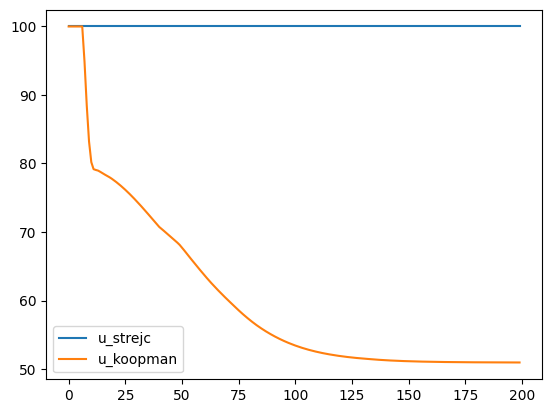

In [410]:
u_strejc = scalerU.inverse_transform(u)[0]
plt.figure()
plt.plot(u_strejc, label='u_strejc')
plt.plot(u_koopman, label='u_koopman')
plt
plt.legend()
plt.show()

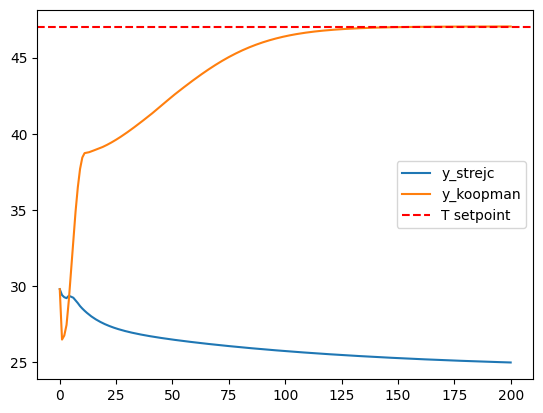

In [411]:
y_strejc = scaler.inverse_transform(y)
plt.figure()
plt.plot(y_strejc[0, :], label='y_strejc')
plt.plot(y_koopman[0,:], label='y_koopman')
plt.axhline(y=ys, color='r', linestyle='--', label='T setpoint')
plt.legend()
plt.show()

In [412]:
J_koopman = 0
J_strejc = 0
u_ktest = scalerU.transform(u_koopman.reshape(-1,1))
u_stest = scalerU.transform(u_strejc.reshape(-1,1))
y_ktest = scaler.transform(y_koopman.T)
y_stest = scaler.transform(y_strejc.T)
for i in range(sim_length):
    J_koopman += Qy*y_ktest[i,0]**2 + Qu*u_ktest[i]**2
    J_strejc += Qy*y_stest[i,0]**2 + Qu*u_stest[i]**2

In [413]:
sum(Qu*(u_ktest**2))

array([222.30564601])

In [414]:
sum(Qu*(u_stest**2))

array([2144.64285714])

In [415]:
J_koopman/J_strejc
#9386 32 32 32 40


array([[0.0625607]])

In [416]:
J_koopman

array([[876.75049345]])

In [417]:
J_strejc

array([[14014.39729758]])

In [418]:
# BEZ ŠUMU
# 1.3% skok z dola
# 6.5% skok z hora - divné správanie

# SO ŠUMOM
# 1.2% skok z dola
# 0.0001 - divné správanie
